In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext
import statsmodels.api as sm


/home/savvas/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9)})

In [3]:
pbp_df = pd.read_csv('data/pbp_2017.csv', low_memory=False)
rosters_df = pd.read_csv('data/team_2017_rosters.csv')

In [4]:
# replace . with _
pbp_df.columns = pbp_df.columns.str.replace('.', '_')

In [5]:
# keep all qb pass attempt
qb_pass_df = (pbp_df.query('PassAttempt == 1')
                    .merge(rosters_df[['GSIS_ID', 'Player', 'Pos']], how='left', 
                           left_on='Passer_ID', right_on='GSIS_ID')
                    .query('Pos == "QB"'))

In [6]:
# # some plays are labeled as both a sack and a pass attempts, they should be
# # one or the other
# # For the 2017 pbp data I found 17 instances where this mislabeling happened
# # I manually checked the description in another notebook, 
# # they tend to be plays that were challenged and reversed
# # here I correct the issue
sack_and_pass_mask = (qb_pass_df.Sack==1) & (qb_pass_df.PassAttempt==1)
corrected_sack = np.array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1])
corrected_pass = 1 - corrected_sack
qb_pass_df.loc[sack_and_pass_mask, 'Sack'] = corrected_sack
qb_pass_df.loc[sack_and_pass_mask, 'PassAttempt'] = corrected_pass

In [7]:
player_grpby = qb_pass_df.groupby(['GSIS_ID', 'Player'])

qb_ypa_df = player_grpby[['Yards_Gained', 'PassAttempt']].sum().reset_index()

qb_ypa_df['YPA'] = qb_ypa_df.Yards_Gained / qb_ypa_df.PassAttempt

qb_ypa_df.sort_values('YPA', ascending=False).head(10)

,GSIS_ID,Player,Yards_Gained,PassAttempt,YPA
50,00-0031800,Taylor Heinicke,10,1,10.000000
22,00-0027854,Sam Bradford,380,42,9.047619
45,00-0031345,Jimmy Garoppolo,1560,176,8.863636
37,00-0030524,Landry Jones,239,28,8.535714
64,00-0033537,Deshaun Watson,1699,202,8.410891
1,00-0020531,Drew Brees,4377,534,8.196629
67,00-0033873,Patrick Mahomes,284,35,8.114286
47,00-0031503,Jameis Winston,3524,439,8.027335
7,00-0023436,Alex Smith,4040,504,8.015873
61,00-0033106,Jared Goff,3813,476,8.010504


In [8]:
watson_id = rosters_df.loc[rosters_df.Player == 'Jimmy Garoppolo', 'GSIS_ID'].values
watson_id

array(['00-0031345'], dtype=object)

In [9]:
watson_passes_df = qb_pass_df.loc[qb_pass_df.Player == 'Deshaun Watson']

In [10]:
# double check only one player is named Jimmy Garoppolo
watson_passes_df.groupby(['Player', 'GSIS_ID']).count()

,,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season,Pos
Player,GSIS_ID,,,,,,,,,,,,,,,,,,,,,
Deshaun Watson,00-0033537,202,202,202,202,202,202,202,202,202,202,...,202,202,200,200,202,200,202,200,202,202


In [11]:
watson_passes_df.Yards_Gained.sum() / watson_passes_df.Yards_Gained.size

8.410891089108912

In [12]:
with NumpyRNGContext(42):
    watson_posterior = bb.mean(watson_passes_df.Yards_Gained, 10000)
watson_l, watson_r = bb.highest_density_interval(watson_posterior)

In [13]:
watson_l

6.86822336837321

In [14]:
watson_r

9.978104836038987

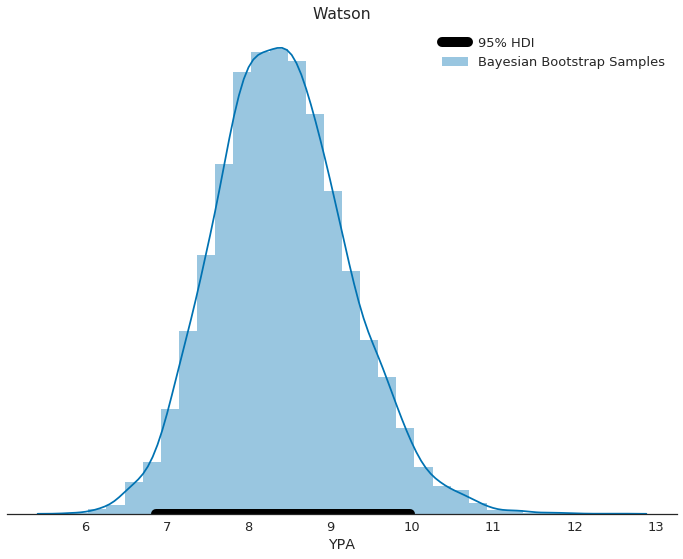

In [44]:
ax = sns.distplot(watson_posterior, bins=30,
                  label='Bayesian Bootstrap Samples')
ax.plot([watson_l, watson_r], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(yticklabels=[], xlabel='YPA', title='Watson')
sns.despine(left=True)
plt.legend();

In [16]:
brees_id = rosters_df.loc[rosters_df.Player == 'Drew Brees', 'GSIS_ID'].values
brees_passes_df = qb_pass_df.loc[qb_pass_df.GSIS_ID == brees_id[0]]

with NumpyRNGContext(42):
    brees_posterior = bb.mean(brees_passes_df.Yards_Gained, 10000)

brees_l, brees_r = bb.highest_density_interval(brees_posterior)

In [17]:
brees_l

7.328395018390543

In [18]:
brees_r

9.040847997805901

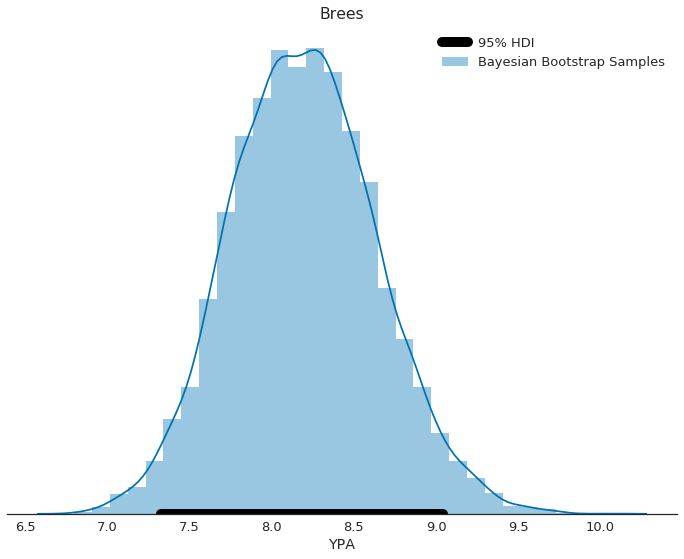

In [45]:
ax = sns.distplot(brees_posterior, bins=30,
                  label='Bayesian Bootstrap Samples')
ax.plot([brees_l, brees_r], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(yticklabels=[], xlabel='YPA', title='Brees')
sns.despine(left=True)
plt.legend();

In [58]:
len(brees_posterior)

10000

In [59]:
len(watson_posterior)

10000

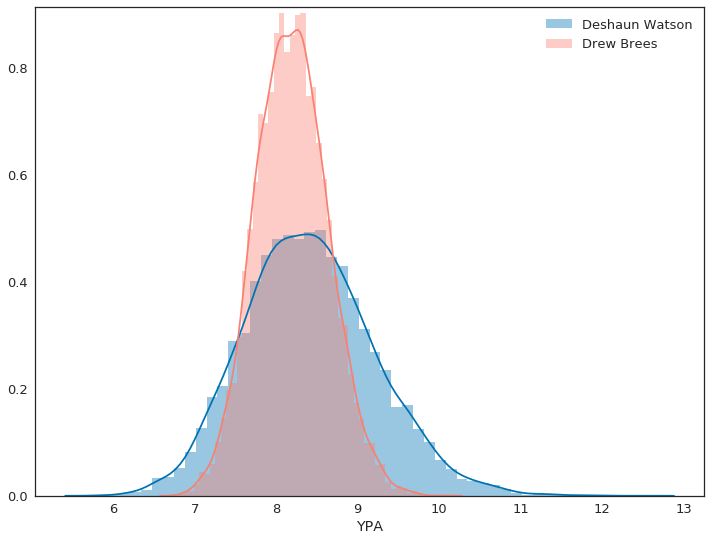

In [62]:
ax = sns.distplot(watson_posterior, label='Deshaun Watson', kde=True)
ax = sns.distplot(brees_posterior, label='Drew Brees', ax=ax, kde=True,
                  color='salmon')
ax.set(xlabel='YPA')
plt.legend();

### How uncertain are we of their difference?

In [47]:
ypa_diff = np.array(watson_posterior) - np.array(brees_posterior)

In [48]:
ypa_diff_l, ypa_diff_r = bb.highest_density_interval(ypa_diff)

In [49]:
ypa_diff_l

-1.5153221691880603

In [50]:
ypa_diff_r

2.0733065860037616

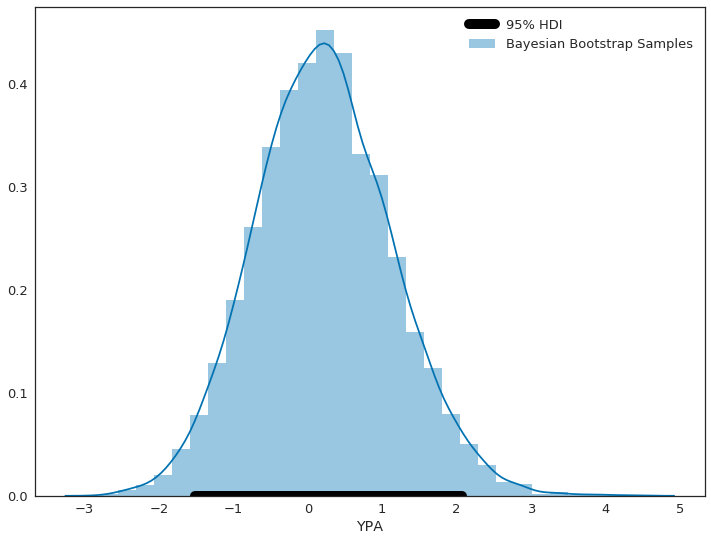

In [52]:
ax = sns.distplot(ypa_diff, label='Bayesian Bootstrap Samples', bins=30)
ax.plot([ypa_diff_l, ypa_diff_r], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='YPA')
plt.legend();

## Comparing multiple players

In [28]:
players = ['Tom Brady', 'Jimmy Garoppolo', 'Drew Brees', 'Deshaun Watson', 
           'Matt Ryan', 'Derek Carr', 'Eli Manning', 'Russell Wilson', 
           'Dak Prescott', 'Aaron Rodgers']
select_players = qb_pass_df.loc[qb_pass_df.Player.isin(players)]

select_players.groupby(['Player', 'GSIS_ID']).size()

Player           GSIS_ID   
Aaron Rodgers    00-0023459    238
Dak Prescott     00-0033077    488
Derek Carr       00-0031280    515
Deshaun Watson   00-0033537    202
Drew Brees       00-0020531    534
Eli Manning      00-0022803    571
Jimmy Garoppolo  00-0031345    176
Matt Ryan        00-0026143    526
Russell Wilson   00-0029263    551
Tom Brady        00-0019596    580
dtype: int64

In [29]:
def create_avg_ypa_data(group, n_replications=10000, alpha=0.05,
                        col='Yards_Gained'):
    posterior = bb.mean(group[col], n_replications=n_replications)
    lower_ci, upper_ci = bb.highest_density_interval(posterior, alpha=0.05)
    pass_yards = group[col].sum()
    pass_attempts = len(group[col])
    avg_ypa = pass_yards / pass_attempts
    data = pd.Series({'posterior': posterior,
                      'lower_ci': lower_ci,
                      'upper_ci': upper_ci,
                      'lower_ci_diff': lower_ci - avg_ypa,
                      'upper_ci_diff': upper_ci - avg_ypa,
                      'avg_ypa': avg_ypa,
                      'pass_attempts': pass_attempts,
                      'pass_yards': pass_yards})
    return data

In [30]:
with NumpyRNGContext(42):
    avg_ypa_df = (select_players.groupby(['Player', 'GSIS_ID'])
                                .apply(create_avg_ypa_data)
                                .reset_index())

In [31]:
avg_ypa_df

,Player,GSIS_ID,avg_ypa,lower_ci,lower_ci_diff,pass_attempts,pass_yards,posterior,upper_ci,upper_ci_diff
0,Aaron Rodgers,00-0023459,7.004202,5.763476,-1.240726,238,1667,"[7.5267253995459, 5.985977566891696, 8.0259466...",8.293332,1.289131
1,Dak Prescott,00-0033077,6.895492,6.031921,-0.863571,488,3365,"[7.374643045669682, 7.016246088522113, 7.00699...",7.835330,0.939838
2,Derek Carr,00-0031280,6.836893,6.014416,-0.822477,515,3521,"[7.002098189563915, 6.7570364683094715, 6.2430...",7.733186,0.896293
3,Deshaun Watson,00-0033537,8.410891,6.867164,-1.543727,202,1699,"[7.581715465505969, 8.359984379420926, 8.51180...",10.001237,1.590346
4,Drew Brees,00-0020531,8.196629,7.327858,-0.868771,534,4377,"[8.517381604977551, 8.582980046558506, 8.15344...",9.048887,0.852258
5,Eli Manning,00-0022803,6.136602,5.430728,-0.705875,571,3504,"[6.247016460052668, 6.225076282451843, 5.71691...",6.836751,0.700149
6,Jimmy Garoppolo,00-0031345,8.863636,7.362715,-1.500921,176,1560,"[8.028539577650879, 8.73604246261854, 10.17385...",10.448108,1.584472
7,Matt Ryan,00-0026143,7.857414,7.042917,-0.814497,526,4133,"[8.153517850851006, 7.5329856611622095, 8.3011...",8.687697,0.830283
8,Russell Wilson,00-0029263,7.299456,6.471474,-0.827982,551,4022,"[8.112631253695302, 7.972008504871432, 7.32941...",8.186281,0.886826
9,Tom Brady,00-0019596,7.851724,7.052331,-0.799394,580,4554,"[7.597081236562174, 7.585891619580395, 7.48233...",8.640209,0.788485


In [32]:
ypa_ci = np.array(list(zip(-avg_ypa_df.lower_ci_diff, 
                            avg_ypa_df.upper_ci_diff))).T

In [33]:
avg_ypa = qb_pass_df.Yards_Gained.sum() / qb_pass_df.Yards_Gained.size
avg_ypa

7.0705591916408315

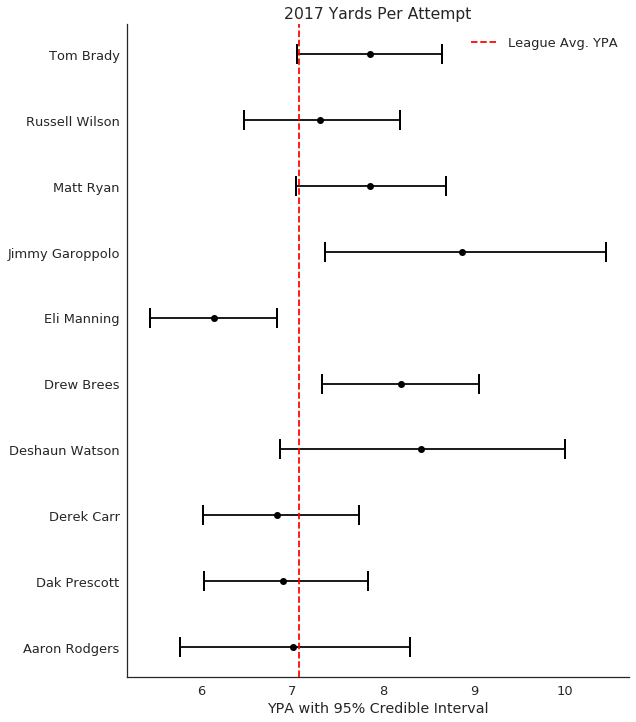

In [34]:
plt.figure(figsize=(9,12))
plt.errorbar('avg_ypa', 'Player', xerr=ypa_ci, data=avg_ypa_df, fmt='ko', 
             capthick=2, capsize=10, label=None)
plt.axvline(avg_ypa, color='r', linestyle='--', label='League Avg. YPA')
plt.xlabel('YPA with 95% Credible Interval')
plt.title('2017 Yards Per Attempt')
plt.legend()
sns.despine();

## Applying the Bayesian Bootstrap to Regression

In [32]:
draft_df = pd.read_csv('https://raw.githubusercontent.com/savvastj/nfl_draft/master/data/clean_data/pfr_nfl_draft_data_CLEAN.csv')

In [33]:
draft_df2 = draft_df.loc[draft_df.Draft_Yr.isin(range(1994, 2013))]

In [34]:
with NumpyRNGContext(369):
    bb_lowess = bb.bayesian_bootstrap_regression(draft_df2.CarAV, 
                                                 draft_df2.Pick, 
                                                 sm.nonparametric.lowess,
                                                 1000, 1000)

In [35]:
bb_lowess = np.array(bb_lowess)

In [36]:
draft_lowess = sm.nonparametric.lowess( draft_df2.CarAV, draft_df2.Pick)

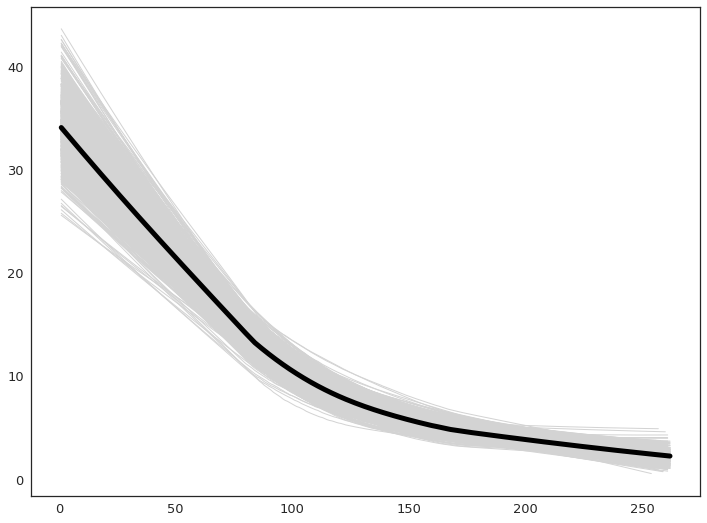

In [37]:
for i, _ in enumerate(bb_lowess):
    plt.plot(bb_lowess[i, :, 0], bb_lowess[i, :, 1], c='lightgray', linewidth=1);
plt.plot(draft_lowess[:, 0], draft_lowess[:, 1], c='k', linewidth=5);

In [42]:
from IPython.display import Video

In [45]:
Video('https://www.stat.auckland.ac.nz/~wild/BootAnim/movies/bootstrap1.mp4')

In [46]:
Video('https://www.stat.auckland.ac.nz/~wild/BootAnim/movies/bootstrap4-1.mp4')